In [ ]:
# !nvidia-smi

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.12 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 30.0/107.7 GB disk)


In [ ]:
%cd {HOME}
!git clone https://github.com/ifzhang/ByteTrack.git
%cd {HOME}/ByteTrack

!sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt

!pip3 install -q -r requirements.txt
!python3 setup.py -q develop
!pip install -q cython_bbox
!pip install -q onemetric
!pip install -q loguru lap thop

from IPython import display
display.clear_output()


import sys
sys.path.append(f"{HOME}/ByteTrack")


import yolox
print("yolox.__version__:", yolox.__version__)

yolox.__version__: 0.1.0


In [ ]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

In [ ]:
!pip install supervision==0.1.0


from IPython import display
display.clear_output()


import supervision
print("supervision.__version__:", supervision.__version__)

supervision.__version__: 0.1.0


In [ ]:
from supervision.draw.color import ColorPalette
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator

In [ ]:
from typing import List

import numpy as np


# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections,
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)

    tracker_ids = [None] * len(detections)

    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

In [ ]:
# settings
MODEL = "yolov8x.pt"

In [ ]:
from ultralytics import YOLO

model = YOLO(MODEL)
model.fuse()

100%|██████████| 131M/131M [00:00<00:00, 160MB/s]


YOLOv8x summary (fused): 268 layers, 68200608 parameters, 0 gradients, 257.8 GFLOPs


In [ ]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names
# class_ids of interest - car, motorcycle, bus and truck
CLASS_ID = [2, 3, 5, 7]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/ByteTrack
/content/ByteTrack
loading Roboflow workspace...
loading Roboflow project...
Ambulance not Detected

0: 640x608 3 cars, 1 truck, 8709.6ms
Speed: 22.5ms preprocess, 8709.6ms inference, 27.0ms postprocess per image at shape (1, 3, 640, 608)
Number of vehicles in the frame: 4


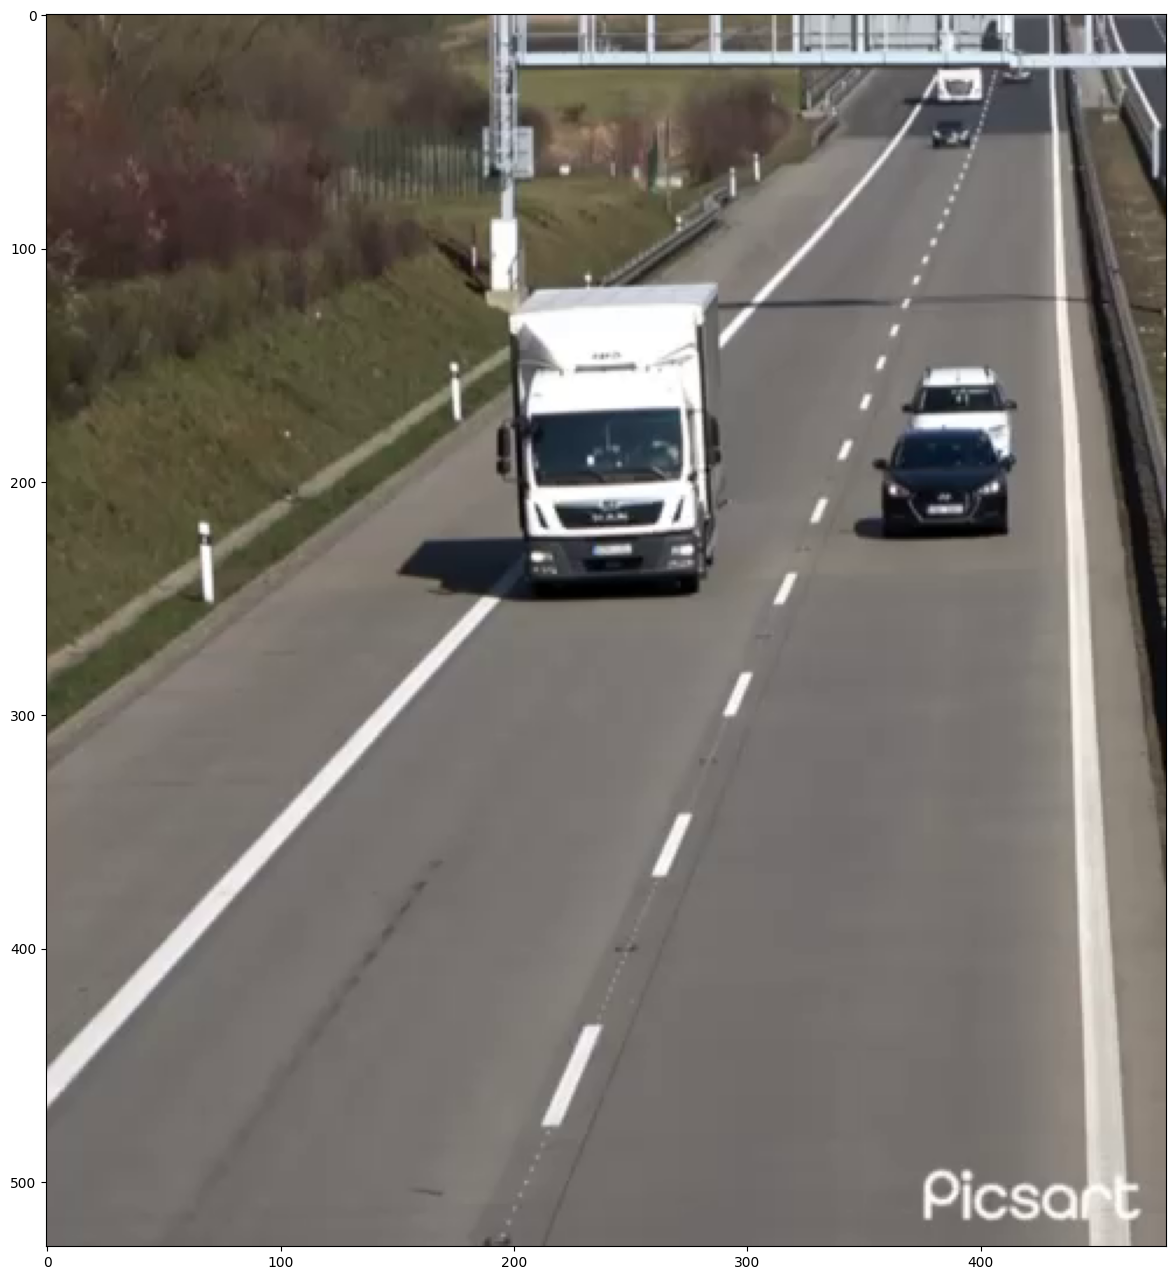

loading Roboflow workspace...
loading Roboflow project...
Ambulance Detected

0: 384x640 2 persons, 13 cars, 2 motorcycles, 2 buss, 3 trucks, 4097.0ms
Speed: 2.7ms preprocess, 4097.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)
Number of vehicles in the frame: 18


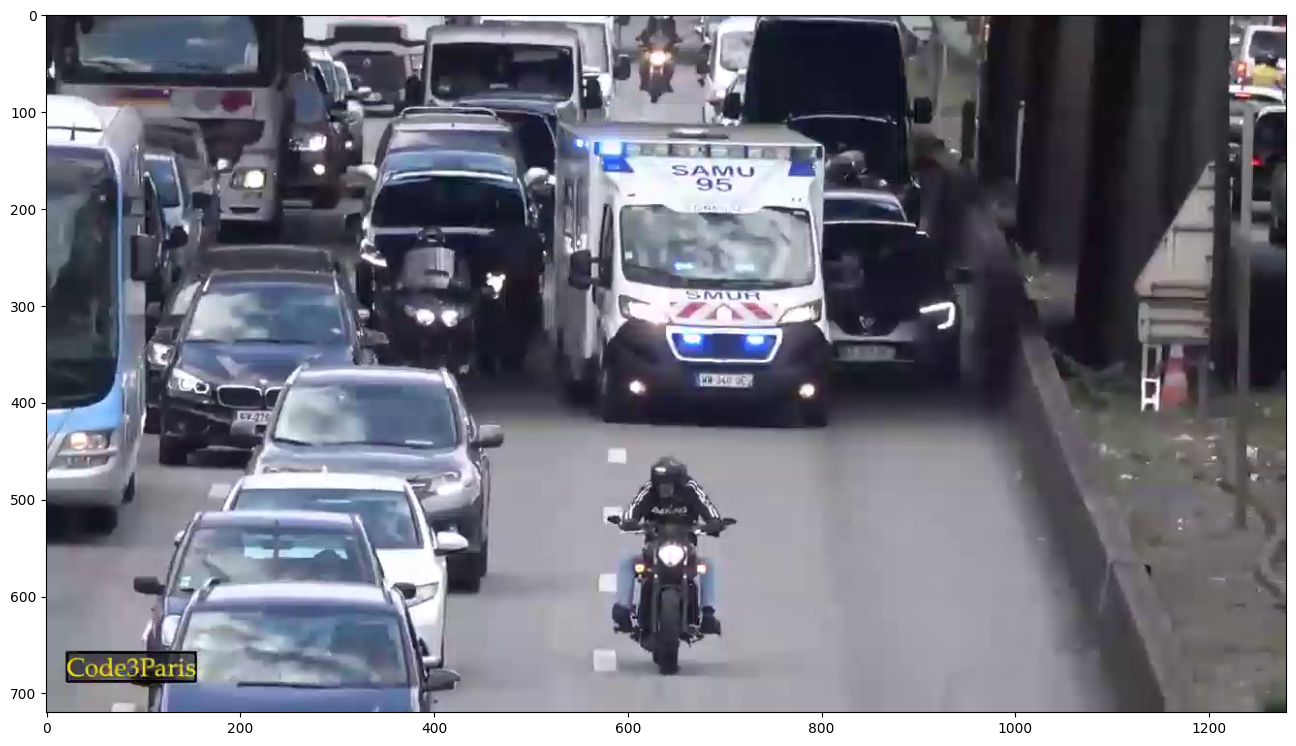

loading Roboflow workspace...
loading Roboflow project...
Ambulance not Detected

0: 544x640 25 cars, 3851.7ms
Speed: 4.2ms preprocess, 3851.7ms inference, 6.1ms postprocess per image at shape (1, 3, 544, 640)
Number of vehicles in the frame: 25


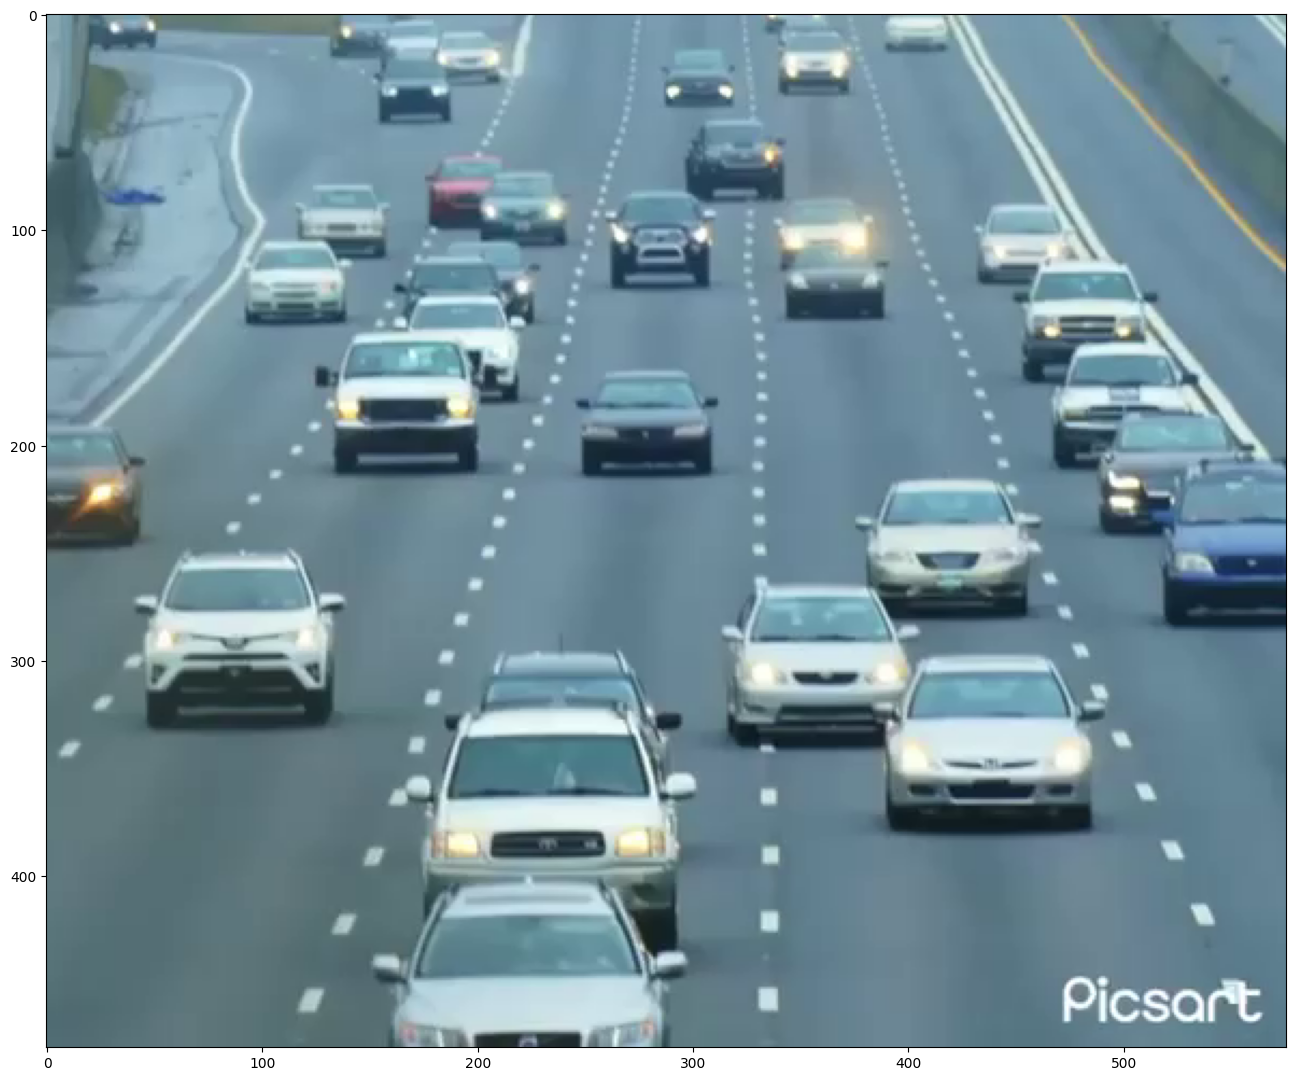

loading Roboflow workspace...
loading Roboflow project...
Ambulance Detected

0: 448x640 3 persons, 5 cars, 1 truck, 4253.3ms
Speed: 3.1ms preprocess, 4253.3ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)
Number of vehicles in the frame: 6


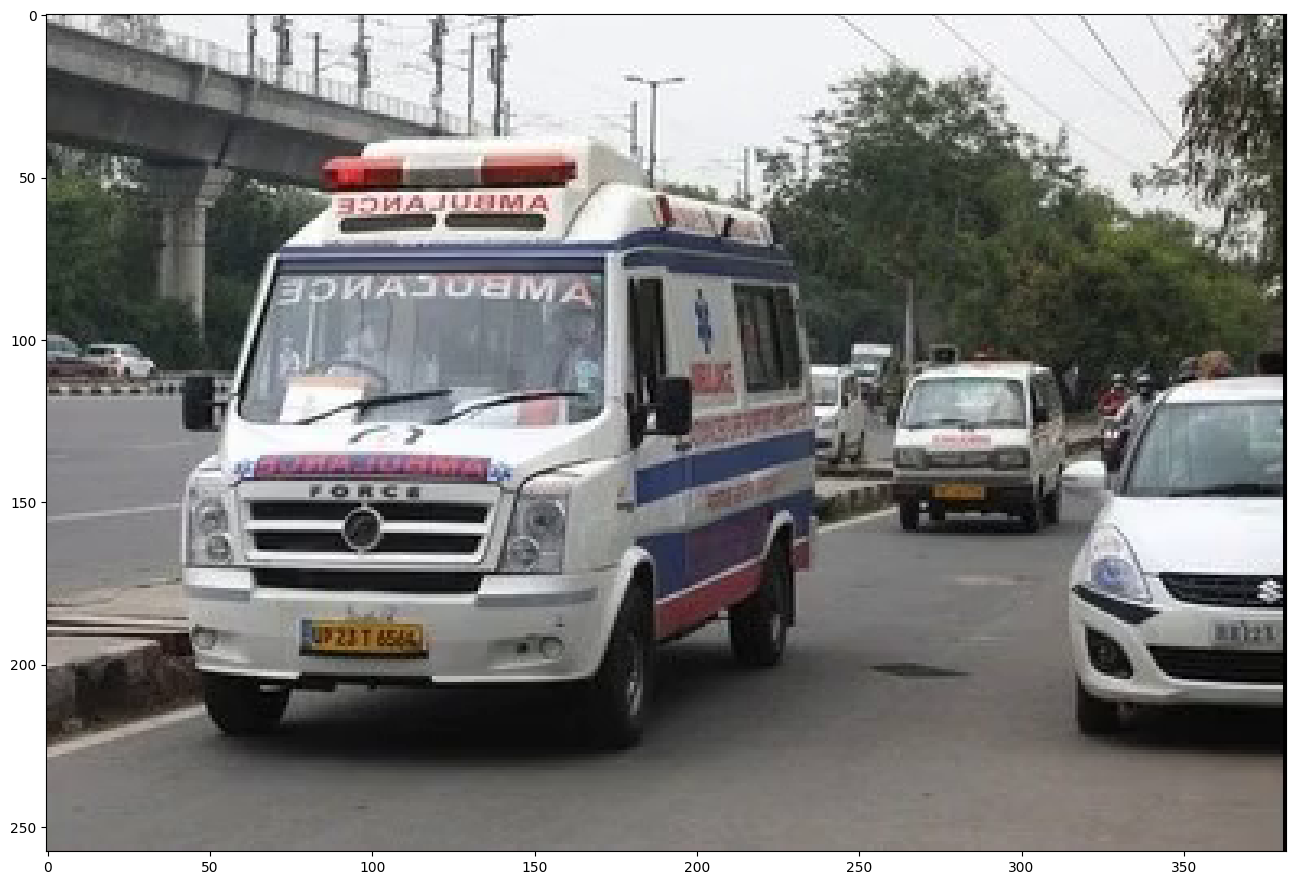

In [ ]:


!pip install Roboflow


import cv2
from PIL import Image

ambulance_present=[]

# Function to convert frame to PNG
def convert_frame_to_png(frame):
    # Convert frame to RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # Convert to PIL Image
    pil_image = Image.fromarray(frame_rgb)
    # Save as PNG
    pil_image.save("/content/drive/MyDrive/abcd.png", format="PNG")


from google.colab import drive
drive.mount('/content/drive')
import os
HOME = os.getcwd()
print(HOME)
%cd {HOME}
x = f"/content/drive/MyDrive/Lane1.mp4"
y = f"/content/drive/MyDrive/Lane3.mp4"
z = f"/content/drive/MyDrive/Lane6.mp4"
a = f"/content/drive/MyDrive/Lane7.mp4"
video_paths = [x,y,z,a]

vehicle_counts = []
vehicle_dict={}

for i in video_paths:
  # create frame generator
  generator = get_video_frames_generator(i)
  # create instance of BoxAnnotator
  box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=1, text_scale=0.5)
  # acquire first video frame
  iterator = iter(generator)
  frame = next(iterator)

  convert_frame_to_png(frame)

  from roboflow import Roboflow
  rf = Roboflow(api_key="yfUJ0k4UgHyxqKkag30N")
  project = rf.workspace().project("ph-ambulances")
  ambulance_model = project.version(1).model

  x=ambulance_model.predict("/content/drive/My Drive/abcd.png", confidence=40, overlap=30).json()
  if 'predictions' in x and len(x['predictions']) >0:
      predicted_class = x['predictions'][0]['class']
  else:
      predicted_class = None
  if predicted_class=='Ambulance':
      ambulance_present.append(1)
      print('Ambulance Detected')
  else:
      ambulance_present.append(0)
      print('Ambulance not Detected')


  # model prediction on single frame and conversion to supervision Detections
  results = model(frame)
  detections = Detections(
      xyxy=results[0].boxes.xyxy.cpu().numpy(),
      confidence=results[0].boxes.conf.cpu().numpy(),
      class_id=results[0].boxes.cls.cpu().numpy().astype(int)
  )

  # format custom labels
  labels = [
      f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
      for _, confidence, class_id, tracker_id
      in detections
  ]


  # count the number of vehicles
  vehicle_count = sum([1 for class_id in detections.class_id if CLASS_NAMES_DICT[class_id] in ['car', 'truck', 'bus', 'motorcycles']])
  vehicle_counts.append(vehicle_count)
  print(f"Number of vehicles in the frame: {vehicle_count}")

  %matplotlib inline
  show_frame_in_notebook(frame, (16, 16))


In [ ]:
green_times = []

# Example inputs
# count_vehicles_lane = [20, 15, 5, 30]  # Count of vehicles in each lane
min_green_time = 20  # Minimum green time for each lane (seconds)
avg_count_vehicles_lane = [15,15,15,15]  # Average count of vehicles at a time in each lane
ambulance_time = 10  # Time required for an ambulance to clear the junction (seconds)
# ambulance_present = [1, 0, 0, 0]  # Boolean indicating the presence of an ambulance (1 if present else 0)

for i in range(len(vehicle_counts)):
    Ai = avg_count_vehicles_lane[i]
    Di = vehicle_counts[i]
    green_time = min_green_time * (1 + Di / Ai) * (1 + ambulance_present[i]) + 0.25*ambulance_present[i] * ambulance_time
    if not ambulance_present[i]:
        x=int(min(60,green_time))
        if x<15:
          x=15
    else:
        x=int(min(90,green_time))
    green_times.append(x)
print("Green times for each lane:", green_times)
print(ambulance_present)
vehicle_dict={"Lane1":[green_times[0],ambulance_present[0]],"Lane2":[green_times[1],ambulance_present[1]],"Lane3":[green_times[2],ambulance_present[2]],"Lane4":[green_times[3],ambulance_present[3]]}
print(vehicle_dict)

sorted_items = sorted(vehicle_dict.items(), key=lambda x: (x[1][1], x[1][0]), reverse=True)

sorted_dict = {}
for key, value in sorted_items:
    sorted_dict[key] = int(value[0]/3)  # Keep only the first element after sorting
    vehicle_dict[key].pop(1)  # Pop the second element from the original dictionary

print(sorted_dict)
# sort1=sorted(green_times,reverse=True)
# # keys=list()
# print(sort1)
# def get_keys(dictionary, search_values):
#     keys_list = ["0","0","0","0"]
#     for key, value in dictionary.items():
#         for i in range(len(search_values)):
#             if value[0] == search_values[i]:
#                 keys_list[i]=key
#                 # print(keys_list)
#     return keys_list
# keys_list=get_keys(vehicle_dict,sort1)
# for i in range(len(sort1)):
#   sort1[i]=sort1[i]/3
# mapped_dict = dict(zip(keys_list, sort1))
# print(mapped_dict)


Green times for each lane: [25, 90, 53, 58]
[0, 1, 0, 1]
{'Lane1': [25, 0], 'Lane2': [90, 1], 'Lane3': [53, 0], 'Lane4': [58, 1]}
{'Lane2': 30, 'Lane4': 19, 'Lane3': 17, 'Lane1': 8}


In [ ]:
from google.colab import files

file_path = '/content/my_dict.py'

with open(file_path, 'w') as file:
    file.write(str(sorted_dict))

files.download('/content/my_dict.py')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/ByteTrack
/content/ByteTrack
loading Roboflow workspace...
loading Roboflow project...
Ambulance not Detected

0: 640x608 3 cars, 1 truck, 4336.7ms
Speed: 7.4ms preprocess, 4336.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 608)
Number of vehicles in the frame: 4


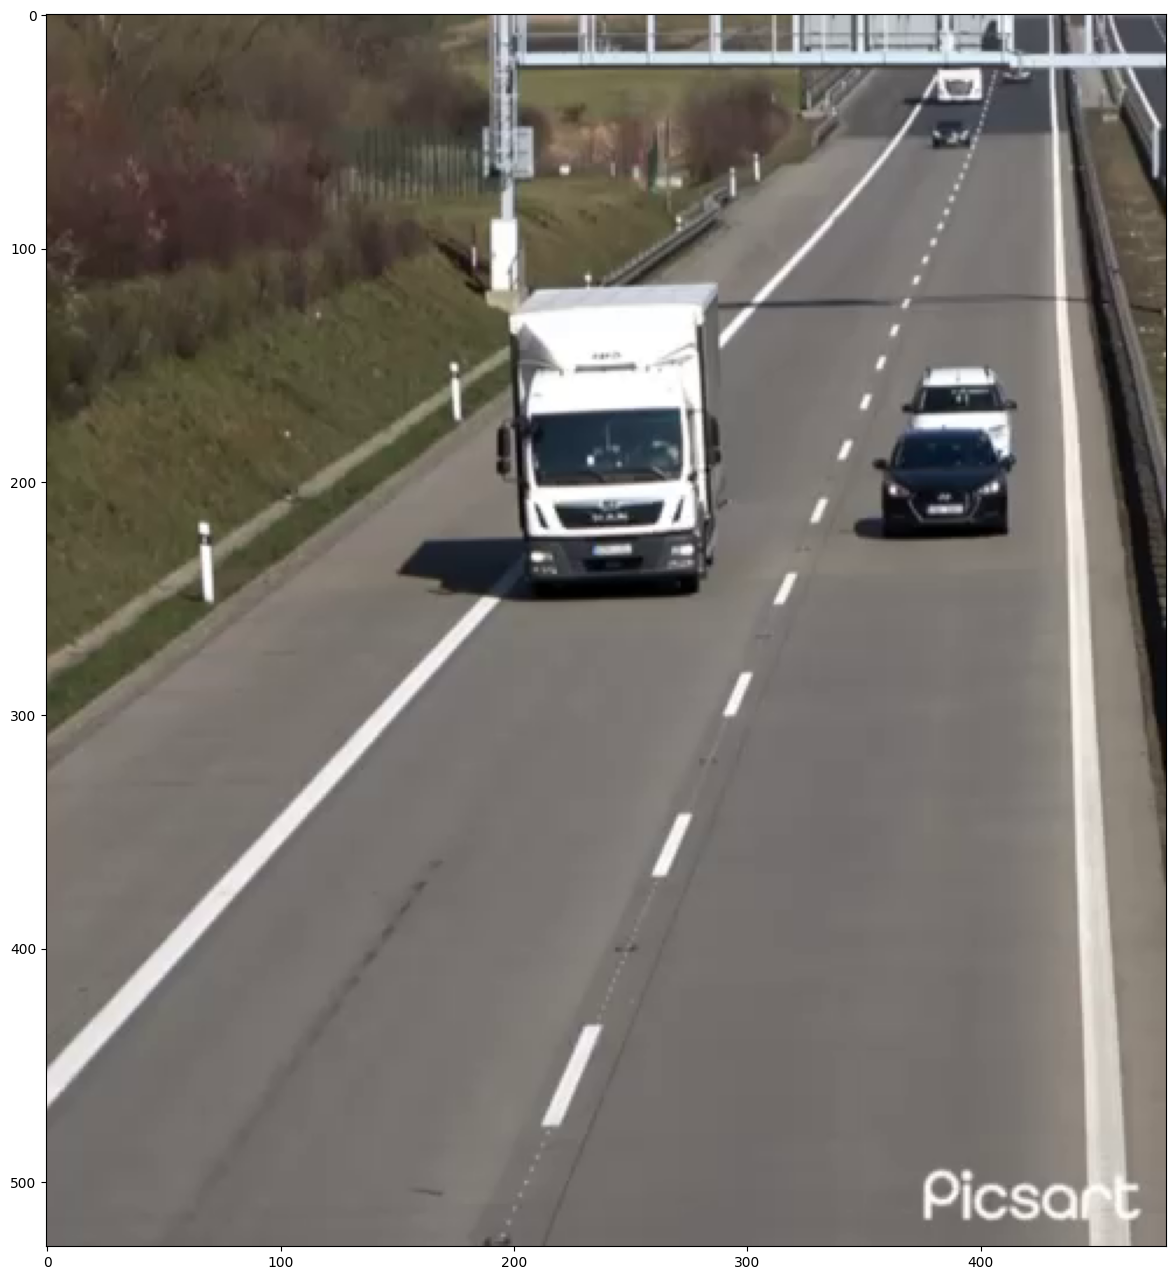

loading Roboflow workspace...
loading Roboflow project...
Ambulance not Detected

0: 640x608 3 persons, 6 cars, 2 motorcycles, 1 truck, 6262.3ms
Speed: 4.5ms preprocess, 6262.3ms inference, 8.7ms postprocess per image at shape (1, 3, 640, 608)
Number of vehicles in the frame: 7


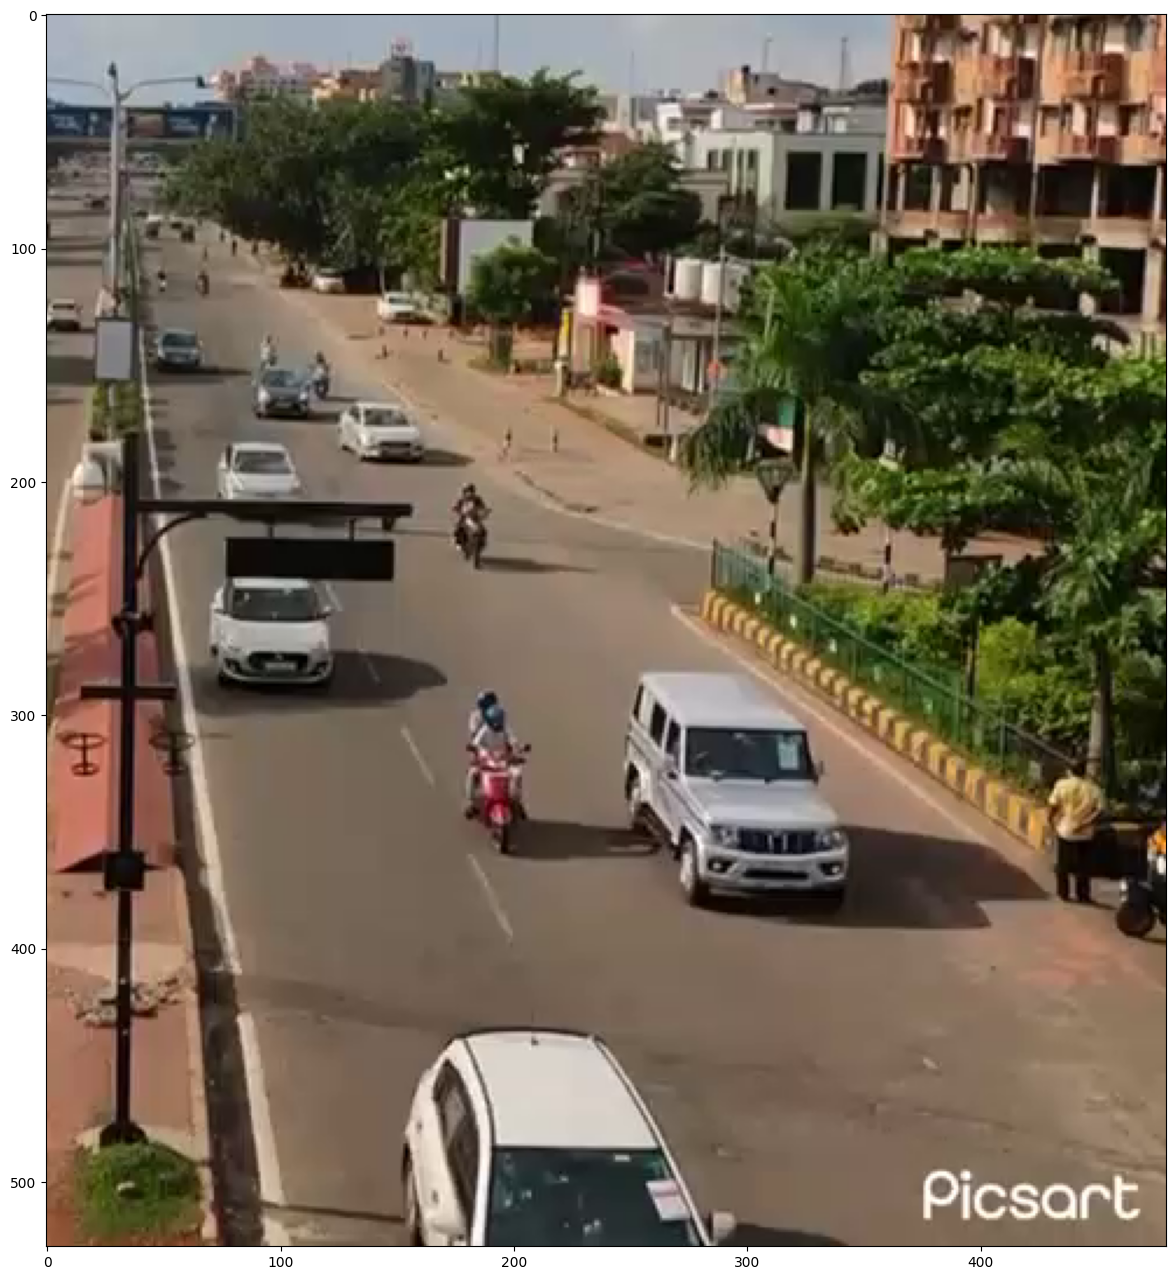

loading Roboflow workspace...
loading Roboflow project...
Ambulance Detected

0: 384x640 2 persons, 13 cars, 2 motorcycles, 2 buss, 3 trucks, 2778.7ms
Speed: 4.1ms preprocess, 2778.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
Number of vehicles in the frame: 18


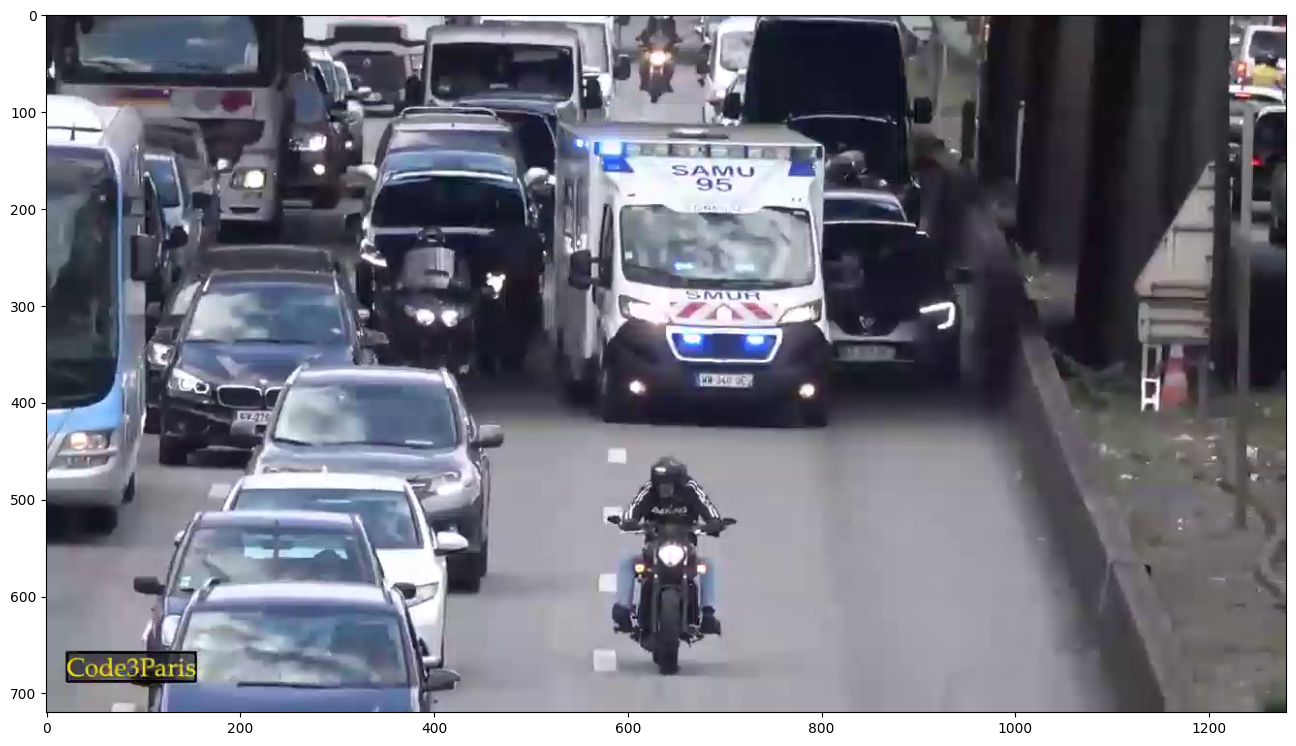

loading Roboflow workspace...
loading Roboflow project...
Ambulance not Detected

0: 640x448 1 person, 16 cars, 4230.5ms
Speed: 3.7ms preprocess, 4230.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)
Number of vehicles in the frame: 16


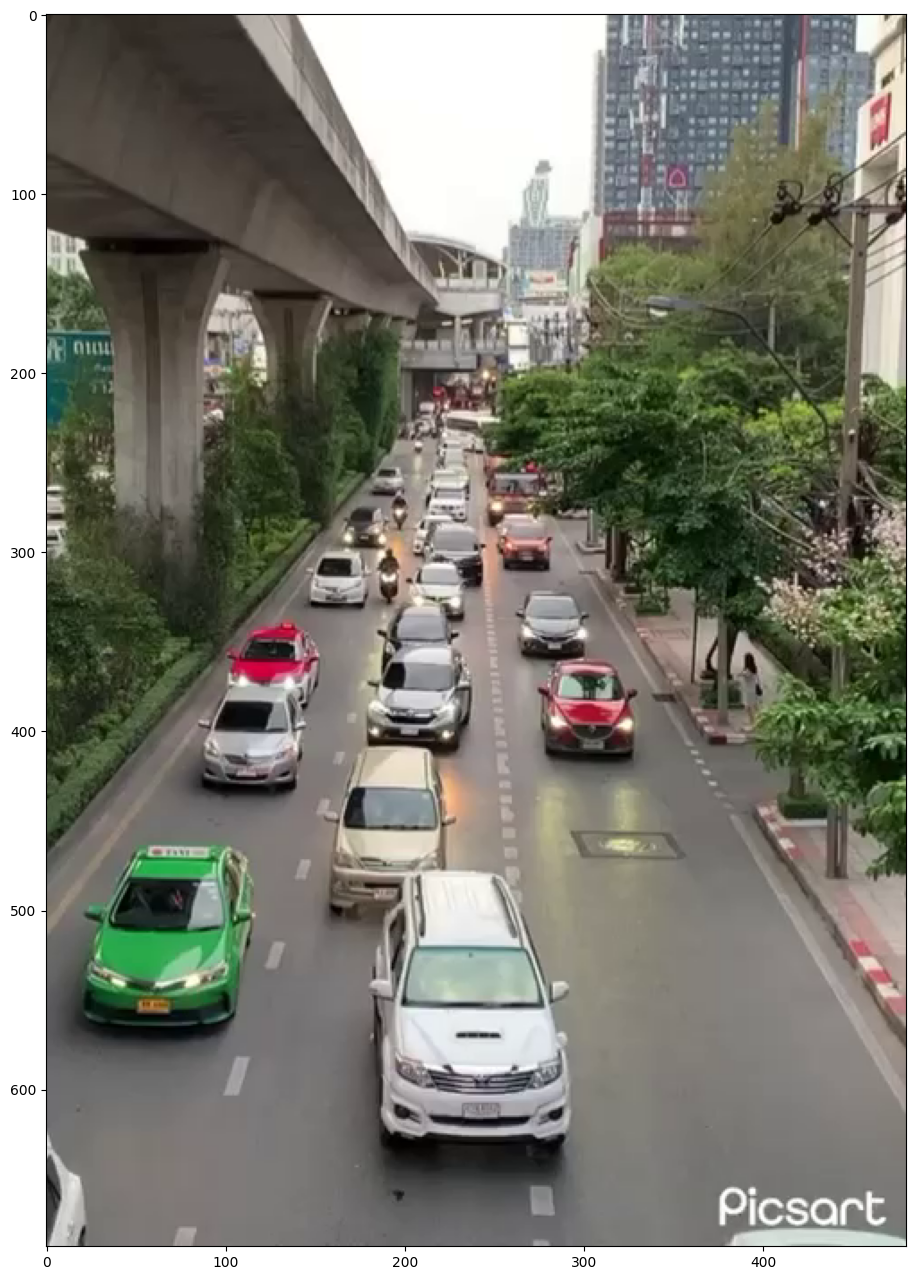

In [ ]:


!pip install Roboflow


import cv2
from PIL import Image

ambulance_present=[]

# Function to convert frame to PNG
def convert_frame_to_png(frame):
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(frame_rgb)
    pil_image.save("/content/drive/MyDrive/abcd.png", format="PNG")


from google.colab import drive
drive.mount('/content/drive')
import os
HOME = os.getcwd()
print(HOME)
%cd {HOME}
x = f"/content/drive/MyDrive/Lane1.mp4"
y = f"/content/drive/MyDrive/Lane2.mp4"
z = f"/content/drive/MyDrive/Lane3.mp4"
a = f"/content/drive/MyDrive/Lane4.mp4"
video_paths = [x,y,z,a]

vehicle_counts = []
vehicle_dict={}

for i in video_paths:
  # create frame generator
  generator = get_video_frames_generator(i)
  # create instance of BoxAnnotator
  # box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=1, text_scale=0.5)
  # acquire first video frame
  iterator = iter(generator)
  frame = next(iterator)

  convert_frame_to_png(frame)

  from roboflow import Roboflow
  rf = Roboflow(api_key="yfUJ0k4UgHyxqKkag30N")
  project = rf.workspace().project("ph-ambulances")
  ambulance_model = project.version(1).model

  x=ambulance_model.predict("/content/drive/My Drive/abcd.png", confidence=40, overlap=30).json()
  if 'predictions' in x and len(x['predictions']) >0:
      predicted_class = x['predictions'][0]['class']
  else:
      predicted_class = None
  if predicted_class=='Ambulance':
      ambulance_present.append(1)
      print('Ambulance Detected')
  else:
      ambulance_present.append(0)
      print('Ambulance not Detected')


  # model prediction on single frame and conversion to supervision Detections
  results = model(frame)
  detections = Detections(
      xyxy=results[0].boxes.xyxy.cpu().numpy(),
      confidence=results[0].boxes.conf.cpu().numpy(),
      class_id=results[0].boxes.cls.cpu().numpy().astype(int)
  )

  # format custom labels
  labels = [
      f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
      for _, confidence, class_id, tracker_id
      in detections
  ]


  # count the number of vehicles
  vehicle_count = sum([1 for class_id in detections.class_id if CLASS_NAMES_DICT[class_id] in ['car', 'truck', 'bus', 'motorcycles']])
  vehicle_counts.append(vehicle_count)
  print(f"Number of vehicles in the frame: {vehicle_count}")

  %matplotlib inline
  show_frame_in_notebook(frame, (16, 16))


In [ ]:
green_times = []

# count_vehicles_lane = [20, 15, 5, 30]  # Count of vehicles in each lane
min_green_time = 20  # Minimum green time for each lane (seconds)
avg_count_vehicles_lane = [15,15,15,15]  # Average count of vehicles at a time in each lane
ambulance_time = 10  # Time required for an ambulance to clear the junction (seconds)
# ambulance_present = [1, 0, 0, 0]  # Boolean indicating the presence of an ambulance (1 if present else 0)

for i in range(len(vehicle_counts)):
    Ai = avg_count_vehicles_lane[i]
    Di = vehicle_counts[i]
    green_time = min_green_time * (1 + Di / Ai) * (1 + ambulance_present[i]) + 0.25*ambulance_present[i] * ambulance_time
    if not ambulance_present[i]:
        x=int(min(60,green_time))
        if x<15:
          x=15
    else:
        x=int(min(90,green_time))
    green_times.append(x)
print("Green times for each lane:", green_times)
print(ambulance_present)
vehicle_dict={"Lane1":[green_times[0],ambulance_present[0]],"Lane2":[green_times[1],ambulance_present[1]],"Lane3":[green_times[2],ambulance_present[2]],"Lane4":[green_times[3],ambulance_present[3]]}
print(vehicle_dict)

sorted_items = sorted(vehicle_dict.items(), key=lambda x: (x[1][1], x[1][0]), reverse=True)

sorted_dict = {}
for key, value in sorted_items:
    sorted_dict[key] = int(value[0]/3)  # Keep only the first element after sorting
    vehicle_dict[key].pop(1)  # Pop the second element from the original dictionary

print(sorted_dict)
# sort1=sorted(green_times,reverse=True)
# # keys=list()
# print(sort1)
# def get_keys(dictionary, search_values):
#     keys_list = ["0","0","0","0"]
#     for key, value in dictionary.items():
#         for i in range(len(search_values)):
#             if value[0] == search_values[i]:
#                 keys_list[i]=key
#                 # print(keys_list)
#     return keys_list
# keys_list=get_keys(vehicle_dict,sort1)
# for i in range(len(sort1)):
#   sort1[i]=sort1[i]/3
# mapped_dict = dict(zip(keys_list, sort1))
# print(mapped_dict)


Green times for each lane: [25, 29, 90, 41]
[0, 0, 1, 0]
{'Lane1': [25, 0], 'Lane2': [29, 0], 'Lane3': [90, 1], 'Lane4': [41, 0]}
{'Lane3': 30, 'Lane4': 13, 'Lane2': 9, 'Lane1': 8}


In [ ]:
from google.colab import files

file_path = '/content/my_dict1.py'

with open(file_path, 'w') as file:
    file.write(str(sorted_dict))

files.download('/content/my_dict1.py')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# # VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

# from roboflow import Roboflow
# rf = Roboflow(api_key="yfUJ0k4UgHyxqKkag30N")
# project = rf.workspace().project("ph-ambulances")
# ambulance_model = project.version(1).model

# x=ambulance_model.predict("/content/drive/My Drive/abcd.png", confidence=40, overlap=30).json()
# if 'predictions' in x and len(x['predictions']) >0:
#     predicted_class = x['predictions'][0]['class']
# else:
#     predicted_class = None
# if predicted_class=='Ambulance':
#     # ambulance_present.append(1)
#     print("yes")
# else:
#     # ambulance_present.append(0)
#     print("no")
# # print(ambulance_present)


In [ ]:
# from tqdm.notebook import tqdm


# # create BYTETracker instance
# byte_tracker = BYTETracker(BYTETrackerArgs())
# # create VideoInfo instance
# video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
# # create frame generator
# generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# # create LineCounter instance
# line_counter = LineCounter(start=LINE_START, end=LINE_END)
# # create instance of BoxAnnotator and LineCounterAnnotator
# box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
# line_annotator = LineCounterAnnotator(thickness=4, text_thickness=4, text_scale=2)

# # open target video file
# with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
#     # loop over video frames
#     for frame in tqdm(generator, total=video_info.total_frames):
#         # model prediction on single frame and conversion to supervision Detections
#         results = model(frame)
#         detections = Detections(
#             xyxy=results[0].boxes.xyxy.cpu().numpy(),
#             confidence=results[0].boxes.conf.cpu().numpy(),
#             class_id=results[0].boxes.cls.cpu().numpy().astype(int)
#         )
#         # filtering out detections with unwanted classes
#         mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
#         detections.filter(mask=mask, inplace=True)
#         # tracking detections
#         tracks = byte_tracker.update(
#             output_results=detections2boxes(detections=detections),
#             img_info=frame.shape,
#             img_size=frame.shape
#         )
#         tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
#         detections.tracker_id = np.array(tracker_id)
#         # filtering out detections without trackers
#         mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
#         detections.filter(mask=mask, inplace=True)
#         # format custom labels
#         labels = [
#             f"#{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
#             for _, confidence, class_id, tracker_id
#             in detections
#         ]
#         # updating line counter
#         line_counter.update(detections=detections)
#         # annotate and display frame
#         frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
#         line_annotator.annotate(frame=frame, line_counter=line_counter)
#         sink.write_frame(frame)